# Low Light Response Analysis

This notebook provides the steps to analyze the waveform produced by real data from a single SiPM low light response. Multiple estimation procedures are implemented to speed up the extraction of the relevant parameters:

[__1.__](#Gaussian-Parameter-Estimation) Gaussian peaks are fit to the raw data to extract estimates for 6 of the 9 total variables. 

[__2.__](#Simplified-Fitting-Routine) A simplified fitting routine is run using the results of the gaussian estimation in order to find estimates for the remaining 3 variables. The 6 parameters with an estimate from the gaussian are fixed, and the 3 without an estimate area allowed to float. The results provide estimates for the other 3 variables.

[__3.__](#Final-Fit) The final fit is run where all 9 variables are allowed to float, and each of their estimates based on the previous two steps are passed to the fitting routine to help direct it where to expect the final correct values. The upper and lower bounds for the variables are also set based on their estimated value and what is logically reasonable, erring toward a smaller area to help speed up processing. A program is implemented to rerun the fit if the bounds selected are too limiting to avoid returning innacurate fits

We first start by importing all the packages we will need

In [1]:
import sipmanalyze.estimate as est
import sipmpdf.pdf as PDF
import zfit
import numpy as np
import sipmanalyze.plotting as plot
import datetime

/srv/.env/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
/srv/.env/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Importing Data
Here we import lowlight response data from a root file and save the data in an accessible format and plot the results.

The results of the imported data are saved in a dictionary titled _import_data_results_ which will be called upon later.

The figure and axis of the plot are returned if the user wishes to make any further edits

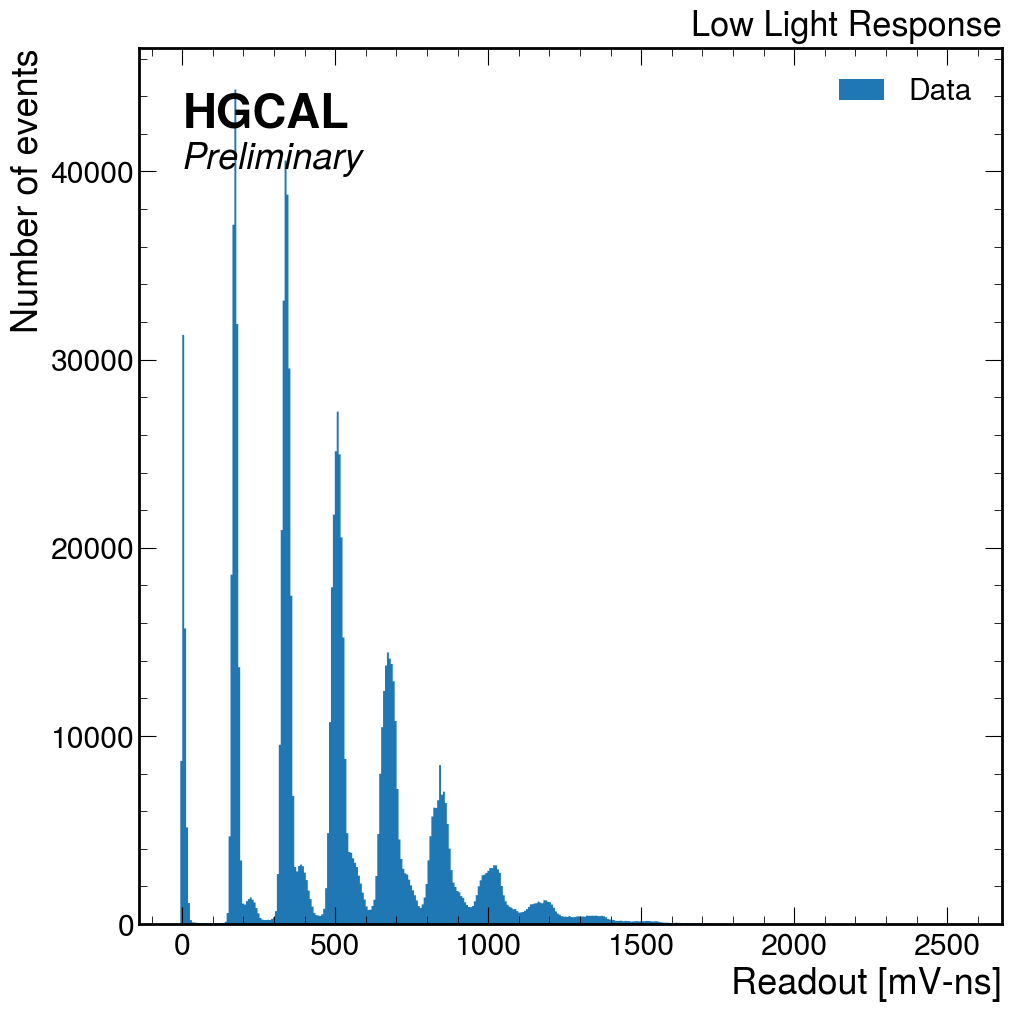

In [2]:
root_1="data/waveform_example.root"
root_2="data/picoblock_20190430_lasertrigger.root"
root_3="data/picoblock_laser_20190521.root"
root_4="data/picoblock_laser_53p1.root"
root_5="data/picoblock_laser_53p6.root"
root_6="data/picoblock_laser_54p1_20190429.root"
root_7="data/picoblock_laser_54p1.root"

starttime=datetime.datetime.now()

file_location=root_2

#import the data
import_data_results=est.import_data(file_location)

#plot the data
fig,ax = est.plot_import_data(import_data_results)

# Gaussian Parameter Estimation

In this step we fit gaussian curves to each of the peaks in the raw data in order to extract estimates for 6 parameters:
pedestal, gain, common noise, pixel noise, poisson mean, poisson borel.

## Gaussian Parameter Estimation: Find Peaks in the Data
We start by finding the locations of each of the peaks in the data. The code for this step uses the function __[find_signal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)__ from scipy.signal. 

The results of the fitting are saved in a dictionary titled _peak_results_.

The figure and axis of the plot are returned if the user wishes to make any further edits
*** 
Optional: <br>
_min_gain_guess_: the minimum gain expected in the data <br>
_min_ratio_guess_: the minimum height allowed for a peak as a fraction of the tallest peak

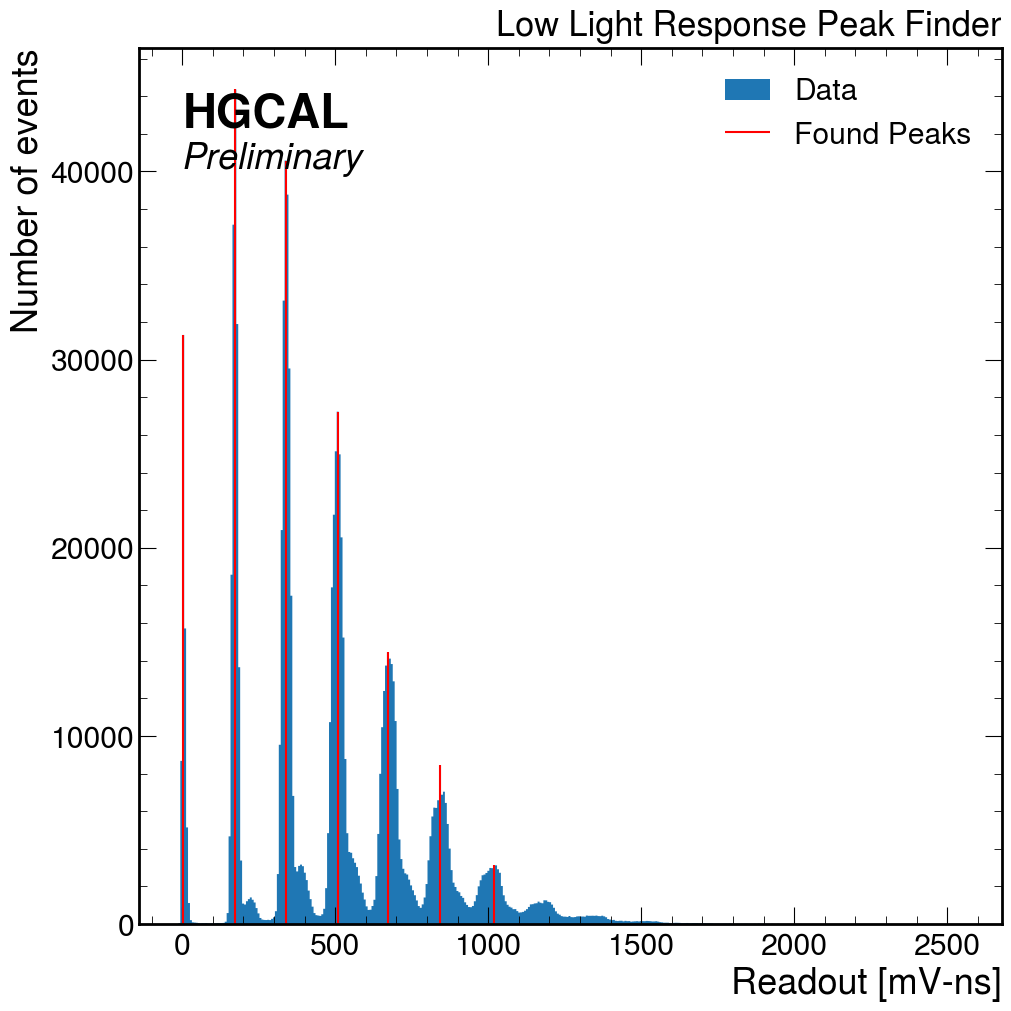

In [3]:
start_of_estimation_routine=datetime.datetime.now()

### Adjustable Optional Parameters for get_peaks ###
min_gain_guess=80 
min_ratio_guess=1/20. 
#############################

#get the peak_results
peak_results =est.get_peaks(import_data_results) 

#plot the peaks
fig,ax = est.plot_peak_results(import_data_results, peak_results)

## Gaussian Paramter Estimation: Fit Gaussian Curves
Here we take the peaks found in the previous step and fit simple gaussian curves to each of them. This is done by passing some of the histogram data centered around each peak to __[curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)__ from scipy.optimize.

Any gaussians which are too wide or where the mean is shifted too far away from the peak are eliminated from the final data as they are poor fits.

The figure and axis of the plot are returned if the user wishes to make any further edits

*** 
Optional: <br>
_gauss_width_: the number of bins to the right and left of the center peak passed to the gaussian fit

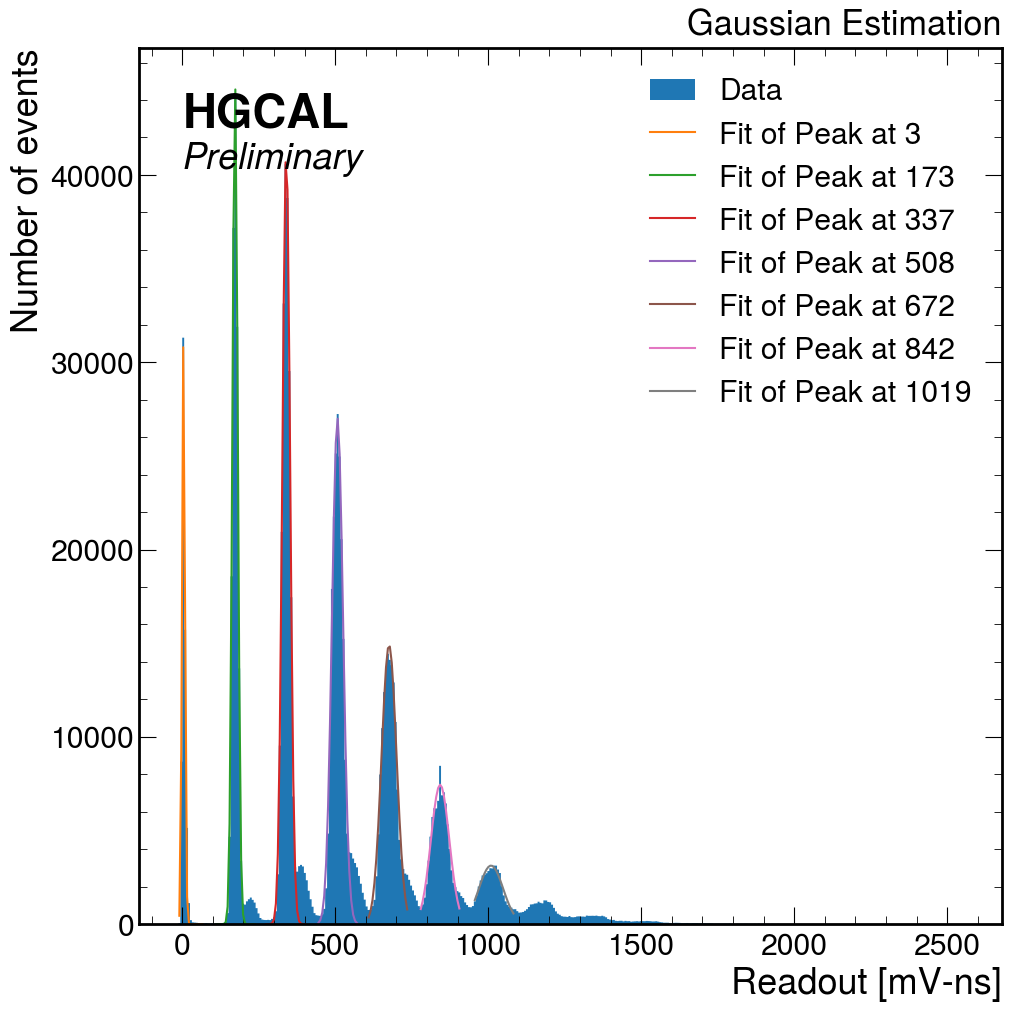

In [4]:
### Adjustable Optional Parameters for gauss_estimate ###
gauss_width=10
#############################

#get the results of gaussian fits
gauss_dict = est.gauss_estimate(import_data_results, peak_results)

#plot the results
fig,ax = est.plot_gauss_estimate(import_data_results,gauss_dict)

## Gaussian Parameter Estimation: Find the Estimates

Taking the results from the previous gaussian fits, we pass them to designated functions which give estimates for the pedestal, gain, common noise, pixel noise, poisson mean, and poisson borel.

The three functions provided work by using __[curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)__ from scipy.optimize. For example, the data for the x-location of the peaks is fit to a linear plot where the slope is the gain and the y-intercept is the pedestal.

In [5]:
#dictionary for parameter estimates
variable_estimates={"pedestal":0,"gain":0,"common_noise":0,"pixel_noise":0,"poisson_mean":0,"poisson_borel":0,"ap_beta":0,"ap_prob":0,"dc_prob":0}

#gain and pedestal estimates
variable_estimates["pedestal"], variable_estimates["gain"]= est.pedestal_gain_est(gauss_dict)

#common noise and pixel noise estimates
variable_estimates["common_noise"], variable_estimates["pixel_noise"] = est.common_pixel_noise_est(gauss_dict)

#poisson mean and poisson borel estimates
variable_estimates["poisson_mean"], variable_estimates["poisson_borel"] = est.poisson_mean_borel_est(gauss_dict)

end_of_estimation_routine=datetime.datetime.now()

# Simplified Fitting Routine

Here we pass the estimates for the 6 parameters to a zfit routine. In this routine the 6 parameters with an estimate are fixed allowing the others to float and get a fast guess for the correct value of the other three (ap_beta, ap_prob, dc_prob). 

In [6]:
#finish variable_estimates dictionary
variable_estimates["ap_beta"]=100
variable_estimates["ap_prob"]=.05
variable_estimates["dc_prob"]=.01

#fixed variables
dc_res_t = 5e-3
N_Events = 100_000


In [7]:
##Initial test fit with 6 fixed parameters and 3 floating parameters
#Define limits for parameters in fit and initial guesses
pedestal = zfit.param.ConstantParameter('pedestal_value_test', variable_estimates["pedestal"])
gain = zfit.param.ConstantParameter('gain_test', variable_estimates["gain"])
common_noise = zfit.param.ConstantParameter('common_noise_test', variable_estimates["common_noise"])
pixel_noise = zfit.param.ConstantParameter('pixel_noise_test', variable_estimates["pixel_noise"])
poisson_mean = zfit.param.ConstantParameter('poisson_mean_test', variable_estimates["poisson_mean"])
poisson_borel = zfit.param.ConstantParameter('poisson_borel_test', variable_estimates["poisson_borel"])
ap_beta = zfit.Parameter('ap_beta_test', variable_estimates["ap_beta"], 20, 120)
ap_prob = zfit.Parameter('ap_prob_test', variable_estimates["ap_prob"], 0.0, 0.3)
dc_prob = zfit.Parameter('dc_prob_test', variable_estimates["dc_prob"], 0.0, 1)
dc_res = zfit.param.ConstantParameter('dc_res_test', dc_res_t)
obs = zfit.Space('x', limits=(-200, +1500))

#Create pdf for low light response
pdf = PDF.SiPMResponsePDF(obs=obs,
                                  pedestal=pedestal,
                                  gain=gain,
                                  ap_beta=ap_beta,
                                  ap_prob=ap_prob,
                                  common_noise=common_noise,
                                  pixel_noise=pixel_noise,
                                  poisson_mean=poisson_mean,
                                  poisson_borel=poisson_borel,
                                  dc_prob=dc_prob,
                                  dc_res=dc_res)

# Declaring the binned phase space in PDF
binning = zfit.binned.RegularBinning(400, -200, 1500, name="x")
obs_bin = zfit.Space("x", binning=binning)
pdf_bin = zfit.pdf.BinnedFromUnbinnedPDF(pdf, obs_bin)

# Making the data container
data_unbinned = zfit.Data.from_numpy(obs=obs, array=np.array(import_data_results["area"]))
data_bin = data_unbinned.to_binned(obs_bin)

# Running the fit
nll_bin = zfit.loss.BinnedNLL(pdf_bin, data_bin)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_bin)
result.hesse()
                         
result

/srv/.env/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1180: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.hesse_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of hesse (which is currently the method name such as `minuit_hesse`or `hesse_np`) has changed to `hesse` (it still adds the old one as well. This will be removed in the future). INSTRUCTIONS: to stay compatible,  change wherever you access the error to 'hesse' (if you don't explicitly specify the name in hesse(...).
  warn_changed_feature(message, "hesse_name")


FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7fdfe40f40d0>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7fdfdc68cac0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 1.6e-07 │ 56203.19    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name            value  (rounded)        hesse    at limit
------------  ------------------  -----------  ----------
ap_prob_test           0.0955919  +/- 0.00036       False
ap_beta_test             61.7898  +/-    0.49       False
dc_prob_test            0.272469  +/-  0.0022       False

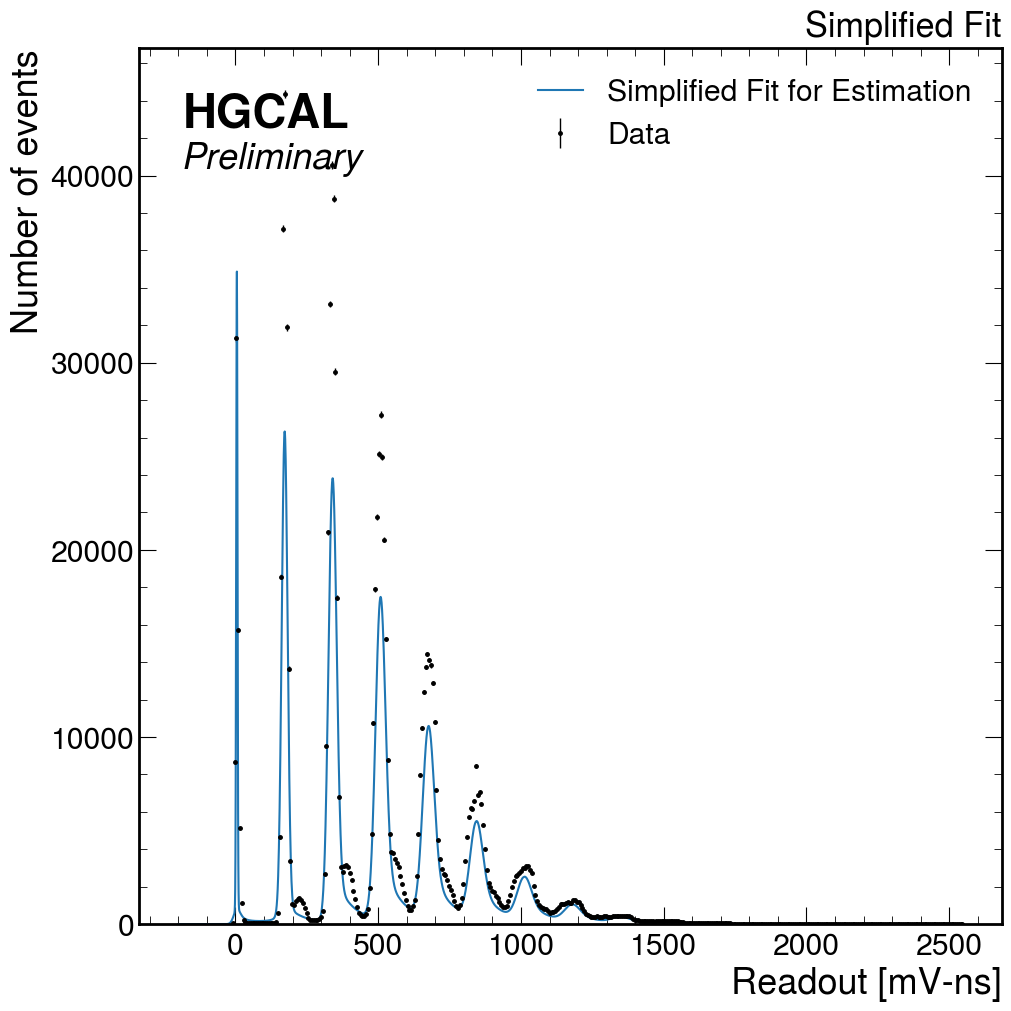

In [8]:
#Plot Fitting Results
fig,ax = plot.make_simple_figure()
plot.plot_data1d(ax=ax,data=import_data_results["h"],label='Data', histtype='errorbar',color='k',markersize=5)
plot.plot_pdf1d(ax=ax,pdf=pdf,data=data_bin,label="Simplified Fit for Estimation")
plot.add_std_label(ax=ax, label='Preliminary', rlabel='Simplified Fit')
ax.set_xlabel('Readout [mV-ns]')
ax.set_ylabel('Number of events')
ax.legend()

## Simplified Fitting Routine: Saving the Results
From the simplified fitting routine we can save the values given for the 3 remaining variables, ap_beta, ap_prob, and dc_prob. While they are not exact, they provide a solid estimate which should be close to their real value. 

In [9]:
#Set estimated values for ap_prob, ap_beta, and dc_prob
variable_estimates["ap_beta"]=result.params[ap_beta]['value']
variable_estimates["ap_prob"]=result.params[ap_prob]['value']
variable_estimates["dc_prob"]=result.params[dc_prob]['value']

end_of_simplified_fit=datetime.datetime.now()

# Final Fit

This final fit uses zfit to extract the best estimate of all 9 variables. The estimated variables found above are passed as starting points to the final fit for faster processing. The bounds of each of the variables are also set as a function of their estimates to create smaller search areas and continue to speed up processing

In [10]:
#Set the limits for each of the variables and ensure that they are reasonable (ex: no probabilities greater than 1)

start_of_final_fit=datetime.datetime.now()

#dictionary containing information to set upper and lower fit limits for zfit
#width: the distance away from the mean that upper and lower bounds should be first set
#lower_max: the lower value that the variable may not pass for logical reasons
#upper_max: the upper value that the variable may not pass for logical reasons
limits_dict={"pedestal":{"width":5},
             "gain":{"width":5,"lower_max":0},
             "common_noise":{"width":5,"lower_max":0},
             "pixel_noise":{"width":2,"lower_max":0},
             "poisson_mean":{"width":2,"lower_max":0},
             "poisson_borel":{"width":.2,"lower_max":0},
             "ap_beta":{"width":15,"lower_max":0},
             "ap_prob":{"width":.07,"lower_max":0,"upper_max":1},
             "dc_prob":{"width":.2,"lower_max":0,"upper_max":1}}


#loop through each estimate and set the upper and lower bounds, ensure that no illogical bounds are set 
#set the values for:
#upper_bound: the current upper bound used in zfit
#lower_bound: the current lower bound used in zfit
limits_dict=est.set_bounds(variable_estimates=variable_estimates,limits_dict=limits_dict)

In [11]:
#Define limits for parameters in fit and initial guesses
pedestal = zfit.Parameter('pedestal', variable_estimates["pedestal"],limits_dict["pedestal"]["lower_bound"],limits_dict["pedestal"]["upper_bound"])
gain = zfit.Parameter('gain', variable_estimates["gain"], limits_dict["gain"]["lower_bound"], limits_dict["gain"]["upper_bound"])
common_noise = zfit.Parameter('common_noise', variable_estimates["common_noise"], limits_dict["common_noise"]["lower_bound"], limits_dict["common_noise"]["upper_bound"])
pixel_noise = zfit.Parameter('pixel_noise', variable_estimates["pixel_noise"], limits_dict["pixel_noise"]["lower_bound"], limits_dict["pixel_noise"]["upper_bound"])
poisson_mean = zfit.Parameter('poisson_mean', variable_estimates["poisson_mean"], limits_dict["poisson_mean"]["lower_bound"], limits_dict["poisson_mean"]["upper_bound"])
poisson_borel = zfit.Parameter('poisson_borel', variable_estimates["poisson_borel"], limits_dict["poisson_borel"]["lower_bound"], limits_dict["poisson_borel"]["upper_bound"])
ap_beta = zfit.Parameter('ap_beta', variable_estimates["ap_beta"], limits_dict["ap_beta"]["lower_bound"], limits_dict["ap_beta"]["upper_bound"])
ap_prob = zfit.Parameter('ap_prob', variable_estimates["ap_prob"], limits_dict["ap_prob"]["lower_bound"], limits_dict["ap_prob"]["upper_bound"])
dc_prob = zfit.Parameter('dc_prob', variable_estimates["dc_prob"], limits_dict["dc_prob"]["lower_bound"], limits_dict["dc_prob"]["upper_bound"])
dc_res = zfit.param.ConstantParameter('dc_res', dc_res_t)
obs = zfit.Space('x', limits=(-200, +1500))

parameters={"pedestal":pedestal,"gain":gain,"common_noise":common_noise,"pixel_noise":pixel_noise,"poisson_mean":poisson_mean,"poisson_borel":poisson_borel,"ap_beta":ap_beta,"ap_prob":ap_prob,"dc_prob":dc_prob}

#Create pdf for low light response
pdf = PDF.SiPMResponsePDF(obs=obs,
                                 pedestal=pedestal,
                                 gain=gain,
                                 ap_beta=ap_beta,
                                 ap_prob=ap_prob,
                                 common_noise=common_noise,
                                 pixel_noise=pixel_noise,
                                 poisson_mean=poisson_mean,
                                 poisson_borel=poisson_borel,
                                 dc_prob=dc_prob,
                                 dc_res=dc_res)

#Run the fitting and rerun up to max_iterations to ensure that the parameters are not hitting the upper or lower bounds, unless those bounds are logical restrictions
max_iterations=10
result, pdf = est.run_iterative_pdf_fit(message=True,pdf=pdf, obs=obs, parameters=parameters, max_iterations=max_iterations, limits_dict=limits_dict, import_data_results=import_data_results)

result

FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7fe0b80eb430>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7fdfe430ca90>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00032 │ 36309.65    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name             value  (rounded)        hesse    at limit
-------------  ------------------  -----------  ----------
pedestal                  6.28407  +/-   0.015       False
gain                      166.056  +/-   0.011       False
common_noise              4.56257  +/-  0.0053       False
pixel_noise               7.82319  +/-  0.0027       False
poisson_mean              2.75336  +/-  0.0023       False
poisson_bo

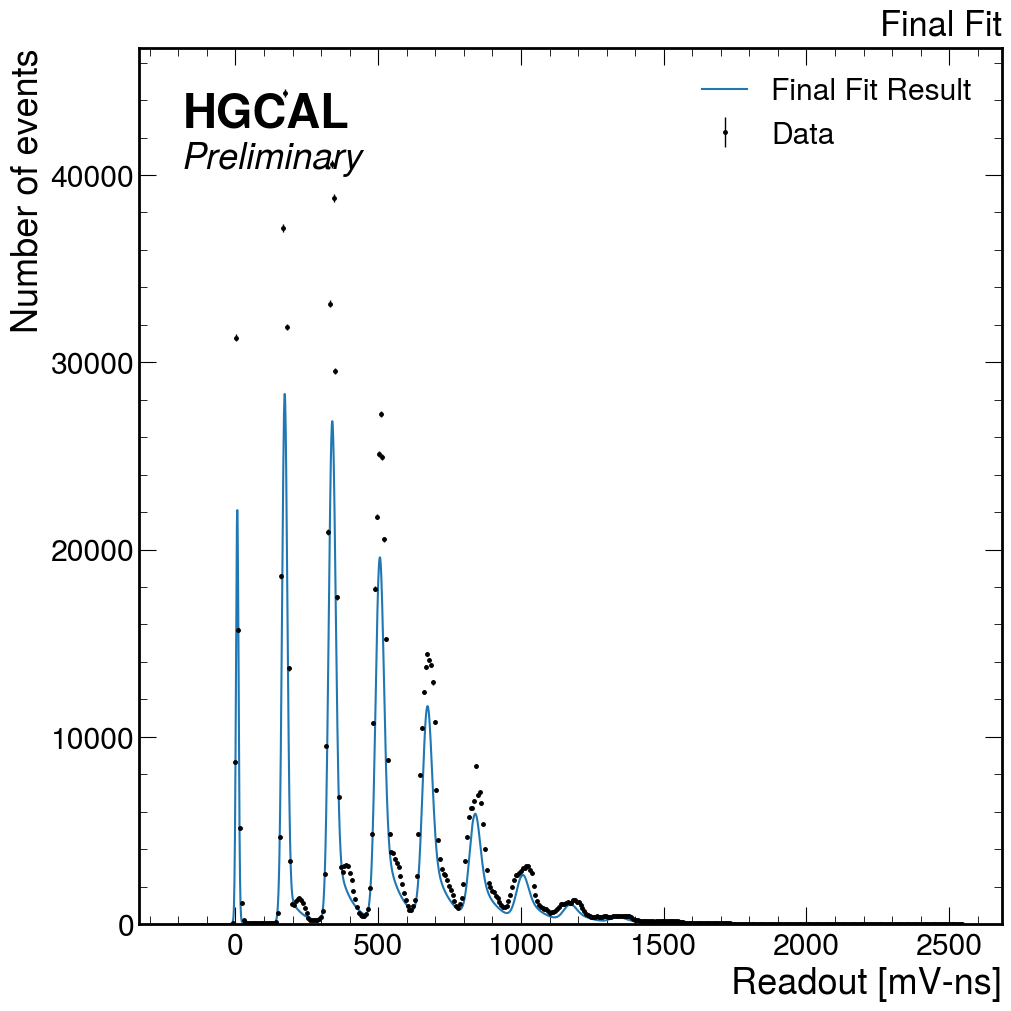

In [12]:
#Plot fitting results
fig,ax = plot.make_simple_figure()
plot.plot_data1d(ax=ax,data=import_data_results["h"],label='Data', histtype='errorbar',color='k',markersize=5)
plot.plot_pdf1d(ax=ax,pdf=pdf,data=data_bin,label="Final Fit Result")
plot.add_std_label(ax=ax, label='Preliminary', rlabel='Final Fit')
ax.set_xlabel('Readout [mV-ns]')
ax.set_ylabel('Number of events')
ax.legend()

In [13]:
#Determine how long each step took
endtime=datetime.datetime.now()

print("The total run took ",endtime-starttime)
print("The gaussian estimation procedure took ",end_of_estimation_routine-start_of_estimation_routine)
print("The simplified fitting routine took ",end_of_simplified_fit-end_of_estimation_routine)
print("The final fitting routine took ",endtime-start_of_final_fit)



The total run took  1:02:28.705865
The gaussian estimation procedure took  0:00:01.046837
The simplified fitting routine took  0:00:34.895642
The final fitting routine took  1:01:50.293528
